# Image Classifier

<a href="https://colab.research.google.com/github/fmcooper/image-classifier-mnist/blob/master/ImageClassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---
Classifying MNIST data.

In [9]:
import sys
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import *

print("\n---------- versions ----------\n")
print("python version: " + sys.version)
print("numpy version: " + np.__version__)
print("matplotlib version: " + mpl.__version__)
print("tensorflow version: " + tf.__version__)
print()

from google.colab import drive
drive.mount('/content/gdrive')

# program variables
SHOW_IMAGES = True
DATASET_NAME = 'mnist'   # mnist or fashion_mnist
NN_TYPE = 'standard'     # standard or cnn
NUM_EPOCHS = 5
BATCH_SIZE = 32
CHECKPOINT_DIR = F'/content/gdrive/My Drive/Colab/imageClassifier/checkpoints/' + "epochs" + str(NUM_EPOCHS) + "_batchsize" + str(BATCH_SIZE) + "/"     # directory checkpoint weights of model are saved
CHECKPOINT_PATH = CHECKPOINT_DIR  + "cp.ckpt"
ENTIRE_SAVE_PATH = CHECKPOINT_DIR + 'trained_entire_model.h5'   # file where entire model is saved


---------- versions ----------

python version: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
numpy version: 1.14.6
matplotlib version: 3.0.3
tensorflow version: 1.13.1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Downloading the data and splitting

In [10]:
print("\n---------- downloading data using keras ----------\n")
if DATASET_NAME == 'mnist':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
elif DATASET_NAME == 'fashion_mnist':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


---------- downloading data using keras ----------



### Exploring the data


---------- exploring data ----------

x_train.shape: (60000, 28, 28)
y_train.shape: (60000,)
x_test.shape: (10000, 28, 28)
y_test.shape: (10000,)


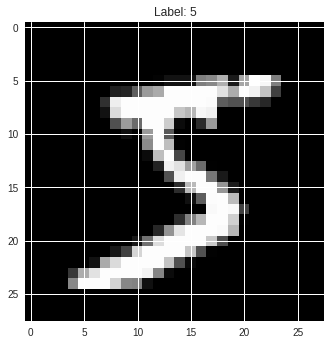

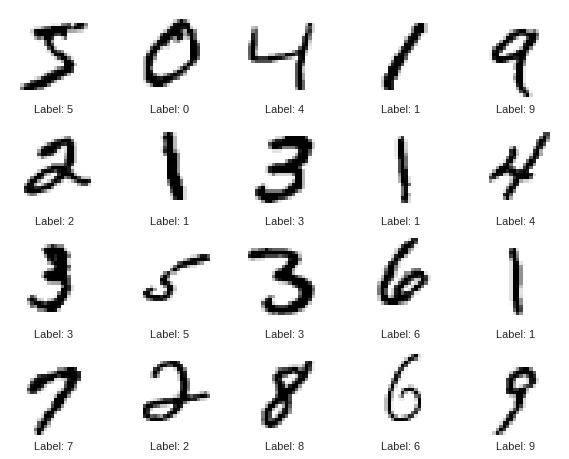

In [11]:
print("\n---------- exploring data ----------\n")
print("x_train.shape: " + str(x_train.shape))
print("y_train.shape: " + str(y_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_test.shape: " + str(y_test.shape))


def printSingleImage(image, label):
    plt.imshow(image.reshape((28,28)), cmap=plt.get_cmap("gray"))
    plt.title("Label: " + str(class_names[label]))
    plt.show()

def printManyImages(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel("Label: " + str(class_names[labels[i]]))
    plt.show()

if SHOW_IMAGES:
    printSingleImage(x_train[0], y_train[0])
    printManyImages(x_train[:20], y_train[:20])

### Preparing data

In [12]:
print("\n---------- preparing data ----------\n")
# Keras API needs arrays to be 4D
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
input_shape = (28, 28, 1)

# normalise by mapping all image data pixels of vals [0, 255] to vals [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255


---------- preparing data ----------



### Building and compiling the model

In [13]:
print("\n---------- building and compiling the model ----------\n")

def create_model():
    if NN_TYPE == 'standard':
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28, 1)),       # input layer: 2D array of 28x28 to 1D array of 784
            tf.keras.layers.Dense(128, activation=tf.nn.relu),      # hidden layer: 128 node dense layer
            tf.keras.layers.Dense(10,  activation=tf.nn.softmax)    # output layer: 10 node softmax represent probabilities (sum of 10 nodes is 1)
        ])

    elif NN_TYPE == 'cnn': 
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                                   input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
        ])
    
    model.compile(optimizer='adam',                         # optimiser: algirithm to adjust model parameters given the loss funtion
                  loss='sparse_categorical_crossentropy',   # loss function: how far are we from what we want?
                  metrics=['accuracy'])                     # metrics: measurements of how well we are doing

    return model

model = create_model()
print(model.summary())


---------- building and compiling the model ----------

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [14]:
print("\n---------- training ----------\n")

# checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_acc', save_weights_only=True, verbose=1)

# train the model on the training data
# epochs is the number of times to iterate over the training dataset
# batch size is the number of training elements to send through before updating model parameters
model.fit(x_train, y_train, verbose=1, shuffle=True, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[cp_callback])

# save entire model
model.save(ENTIRE_SAVE_PATH)


---------- training ----------

Epoch 1/5
59744/60000 [============================>.] - ETA: 0s - loss: 0.2597 - acc: 0.9246
Epoch 00001: saving model to /content/gdrive/My Drive/Colab/imageClassifier/checkpoints/epochs5_batchsize32/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.


W0324 08:56:47.979035 140213637875584 network.py:1430] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f85853f3eb8>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


60000/60000 [==============================] - 7s 122us/sample - loss: 0.2593 - acc: 0.9247
Epoch 2/5
59840/60000 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9665
Epoch 00002: saving model to /content/gdrive/My Drive/Colab/imageClassifier/checkpoints/epochs5_batchsize32/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.


W0324 08:56:55.172047 140213637875584 network.py:1430] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f85853f3eb8>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


60000/60000 [==============================] - 7s 118us/sample - loss: 0.1124 - acc: 0.9665
Epoch 3/5
59712/60000 [============================>.] - ETA: 0s - loss: 0.0766 - acc: 0.9765
Epoch 00003: saving model to /content/gdrive/My Drive/Colab/imageClassifier/checkpoints/epochs5_batchsize32/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.


W0324 08:57:02.355138 140213637875584 network.py:1430] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f85853f3eb8>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


60000/60000 [==============================] - 7s 120us/sample - loss: 0.0768 - acc: 0.9764
Epoch 4/5
59744/60000 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9821
Epoch 00004: saving model to /content/gdrive/My Drive/Colab/imageClassifier/checkpoints/epochs5_batchsize32/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.


W0324 08:57:09.540360 140213637875584 network.py:1430] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f85853f3eb8>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


60000/60000 [==============================] - 7s 120us/sample - loss: 0.0574 - acc: 0.9820
Epoch 5/5
59680/60000 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9861
Epoch 00005: saving model to /content/gdrive/My Drive/Colab/imageClassifier/checkpoints/epochs5_batchsize32/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.


W0324 08:57:16.719104 140213637875584 network.py:1430] This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.Adam object at 0x7f85853f3eb8>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


60000/60000 [==============================] - 7s 120us/sample - loss: 0.0450 - acc: 0.9861


### Testing


---------- testing ----------

10000/10000 [==============================] - 1s 71us/sample - loss: 2.4089 - acc: 0.1097
Accuracy on test dataset with untrained model: 0.1097
10000/10000 [==============================] - 1s 65us/sample - loss: 0.0680 - acc: 0.9779
Accuracy on test dataset with weight loaded model: 0.9779
10000/10000 [==============================] - 1s 71us/sample - loss: 0.0680 - acc: 0.9779
Accuracy on test dataset with entire loaded model: 0.9779

---------- predicting a single image ----------

predictions of our test image: [[2.0832912e-08 2.0687354e-08 1.2473563e-05 3.8218909e-06 8.8675928e-11
  6.0364389e-09 8.8339266e-12 9.9998248e-01 2.3097922e-08 1.1265610e-06]]
maximum value: 7
actual label: 7


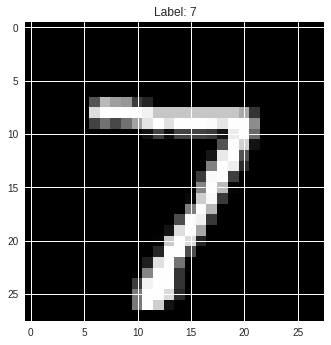

In [15]:
print("\n---------- testing ----------\n")

# fresh model with no training
model = create_model()
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Accuracy on test dataset with untrained model:', test_accuracy)

# loaded weights trained model
model.load_weights(CHECKPOINT_PATH)    # needs to have a model with the same archetecture as original 
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Accuracy on test dataset with weight loaded model:', test_accuracy)

# loaded entire trained model
model = tf.keras.models.load_model(ENTIRE_SAVE_PATH)
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Accuracy on test dataset with entire loaded model:', test_accuracy)


# Individual predictions
print("\n---------- predicting a single image ----------\n")
testImage = x_test[0]
testLabel = y_test[0]
testImage = np.expand_dims(testImage, axis=0)
prediction = model.predict(testImage)

print("predictions of our test image: " + str(prediction))
print("maximum value: " + str(class_names[np.argmax(prediction)]))
print("actual label: " + str(class_names[testLabel]))

if SHOW_IMAGES:
    printSingleImage(testImage, testLabel)